# Multitask Learning

El aprendizaje multi-tarea funje como una técnica de regularización al evitar que las capas profundas de una red se especialicen en una única tarea. Aquí vemos un ejemplo de implementación multitarea aplicado a tres problemas lógicos: AND, OR y XOR.

In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

## Preparación de los datos

Vamos a generar un subconjunto que simule a los problemas lógicos pero con un mayor número de puntos e incluyendo ruido.

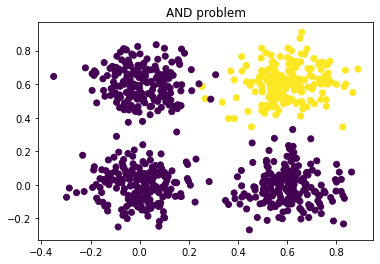

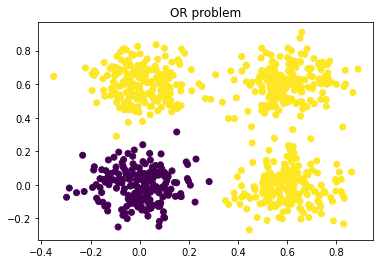

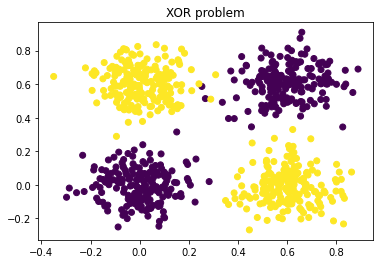

In [2]:
n = 200
x_00 = np.array([np.array([0, 0]) + 0.1*np.random.normal(0,1,2) for i in range(n)]) 
x_11 = np.array([np.array([0.6, 0.6]) + 0.1*np.random.normal(0,1,2) for i in range(n)]) 
x_01 = np.array([np.array([0, 0.6]) + 0.1*np.random.normal(0,1,2) for i in range(n)]) 
x_10 = np.array([np.array([0.6, 0]) + 0.1*np.random.normal(0,1,2) for i in range(n)]) 

y_xor = np.array([0 for i in range(2*n)]+[1 for i in range(2*n)])
y_or = np.array([0 for i in range(n)]+[1 for i in range(3*n)])
y_and = np.array([0 for i in range(n)]+[1 for i in range(n)]+[0 for i in range(2*n)])

x = np.vstack((x_00, x_11, x_01, x_10))
y = np.vstack((y_and, y_or, y_xor)).T

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_test = torch.Tensor(x_train), torch.Tensor(x_test)
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)

plt.scatter(x[:,0], x[:,1], c=y_and)
plt.title('AND problem')
plt.show()
plt.scatter(x[:,0], x[:,1], c=y_or)
plt.title('OR problem')
plt.show()
plt.scatter(x[:,0], x[:,1], c=y_xor)
plt.title('XOR problem')
plt.show()

## Red multi-tarea

Para el aprendizaje multi-tarea, generamos una red que tenga un conjunto de capas ocultas comúnes a las diferentes tareas (en este caso, los diferentes problemas AND, OR y XOR), y posteriormente, tendrá salidas que se especialicen en cada una de las tareas:

![multitask](https://www.researchgate.net/profile/Rajeev-Ranjan-30/publication/309663347/figure/fig1/AS:424537343959052@1478228998238/A-general-multitask-learning-framework-for-deep-CNN-architecture-The-lower-layers-are.png)

De esta forma, podemos asegurar que las representaciones de las capas compartidas no se especialicen en una sola tarea, reduciendo la posibilidad de overfitting.

In [3]:
class MultiTaskFeedForward(nn.Module):
    """
    Red con arquitectura multi-tarea.
    """
    def __init__(self, in_units, rep_units=100, h_units=200):
        super(MultiTaskFeedForward, self).__init__()
        #Capas compartidas
        self.h = nn.Sequential(nn.Linear(in_units, rep_units), nn.Tanh(), 
                               nn.Linear(rep_units, h_units), nn.ReLU())
        #Capa de tarea 1
        self.ffw1 = nn.Sequential(nn.Linear(h_units, 2), nn.Softmax(1))
        #Capa de tarea 2
        self.ffw2 = nn.Sequential(nn.Linear(h_units, 2), nn.Softmax(1))
        #Capa de tarea 3
        self.ffw3 = nn.Sequential(nn.Linear(h_units, 2), nn.Softmax(1))
        
    def forward(self, x):
        #Aplica las capas compartidas
        h = self.h(x)
        #Obtiene salidas para cada tarea
        out1 = self.ffw1(h)
        out2 = self.ffw1(h)
        out3 = self.ffw1(h)
        
        return out1, out2, out3

Generamos entonces el modelo:

In [4]:
model = MultiTaskFeedForward(x.shape[1])
model

MultiTaskFeedForward(
  (h): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ReLU()
  )
  (ffw1): Sequential(
    (0): Linear(in_features=200, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
  (ffw2): Sequential(
    (0): Linear(in_features=200, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
  (ffw3): Sequential(
    (0): Linear(in_features=200, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
)

### Entrenamiento

Entrenamos en cada una de las tareas. Para esto, requeriremos de una función de riesgo que se oriente a cada tarea, así como los optimizadores.

Ya que todos los problemas son de clasificación usamos la entropía cruzada en todos los casos. Los optimizadores pueden ser iguales o distintos.

In [5]:
risk1 = nn.CrossEntropyLoss()
risk2 = nn.CrossEntropyLoss()
risk3 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adagrad(model.parameters())
optimizer2 = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer3 = torch.optim.Adam(model.parameters())

Finalmente, entrenamos para cada uno de los problemas.

100%|██████████| 100/100 [00:00<00:00, 442.64it/s]


[]

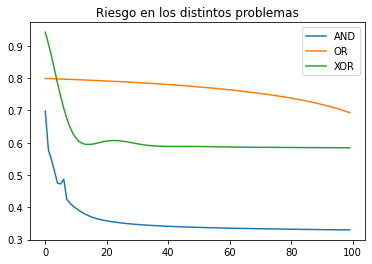

In [6]:
max_it = 100

total_risk1 = []
total_risk2 = []
total_risk3 = []

#Train problema And
for i in tqdm(range(max_it)):
    y_hat1, y_hat2, y_hat3 = model(x_train)
    optimizer1.zero_grad()
    loss1 = risk1(y_hat1, y_train[:,0])
    total_risk1.append(loss1)
    loss1.backward()
    optimizer1.step()
    
#Train problema Or
for i in tqdm(range(max_it)):
    y_hat1, y_hat2, y_hat3 = model(x_train)
    optimizer2.zero_grad()
    loss2 = risk2(y_hat2, y_train[:,1])
    total_risk2.append(loss2)
    loss2.backward()
    optimizer2.step()

#Train problema Xor
for i in tqdm(range(max_it)):
    y_hat1, y_hat2, y_hat3 = model(x_train)
    optimizer3.zero_grad()
    loss3 = risk3(y_hat3, y_train[:,2])
    total_risk3.append(loss3)
    loss3.backward()
    optimizer3.step()


plt.plot(total_risk1, label='AND')
plt.plot(total_risk2, label='OR')
plt.plot(total_risk3, label='XOR')
plt.legend(loc='upper right')
plt.title('Riesgo en los distintos problemas')
plt.plot()

## Evaluación

Podemos ver la evaluación para cada uno de los problemas:

In [7]:
from sklearn.metrics import classification_report

print('\t\t AND problem')
y1, y2, y3 = model(x_test)
print(classification_report(y_test[:,0], y1.argmax(1)))

		 AND problem
              precision    recall  f1-score   support

           0       1.00      0.28      0.44       123
           1       0.30      1.00      0.46        37

    accuracy                           0.45       160
   macro avg       0.65      0.64      0.45       160
weighted avg       0.84      0.45      0.45       160



In [8]:
print('\t\t OR problem')
print(classification_report(y_test[:,1], y2.argmax(1)))

		 OR problem
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.99      0.99      0.99       125

    accuracy                           0.99       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.99      0.99      0.99       160



In [9]:
print('\t\t XOR problem')
print(classification_report(y_test[:,2], y3.argmax(1)))

		 XOR problem
              precision    recall  f1-score   support

           0       0.97      0.47      0.64        72
           1       0.70      0.99      0.82        88

    accuracy                           0.76       160
   macro avg       0.83      0.73      0.73       160
weighted avg       0.82      0.76      0.74       160



## Aprendizaje en las capas compartidas

En las capas que se comparten en todos los problemas, la red aprende una representación que se orienta a la solución de todos los problemas en que fue entrenada. Podemos ver como esta representación evita el sobreajuste al buscar ser capaz de solucionar todos los problemas en los que fue entrenada la red.

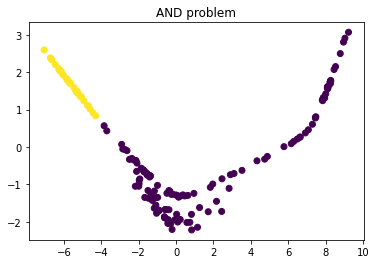

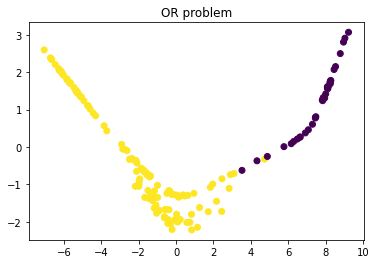

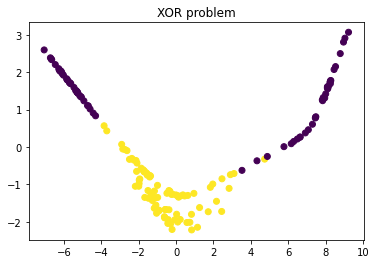

In [10]:
from sklearn.decomposition import PCA

x_red = PCA(2).fit_transform(model.h(x_test).detach().numpy())

plt.scatter(x_red[:,0], x_red[:,1], c=y_test[:,0])
plt.title('AND problem')
plt.show()
plt.scatter(x_red[:,0], x_red[:,1], c=y_test[:,1])
plt.title('OR problem')
plt.show()
plt.scatter(x_red[:,0], x_red[:,1], c=y_test[:,2])
plt.title('XOR problem')
plt.show()